In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import FeatureUnion

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import pickle


from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('3.1ReviewsUpdatedNov21.csv', encoding='utf-8')


# VIEW CLEANED DATA

Text(0.5, 0, 'Target')

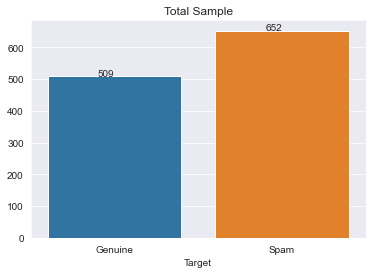

In [3]:
y = df["Target"]
ax = sns.barplot(x=['Genuine','Spam'],
                 y=[sum(y==1),sum(y==0)])
for i,v in enumerate([sum(y==1),sum(y==0)]):
    ax.text(i - .1,v + 1,v)
ax.set_title("Total Sample")
ax.set_xlabel('Target')

In [4]:
df_true = df[df['Target'] == 1]
df_false = df[df['Target']== 0]

In [5]:
print(df_true.describe())

             Userid      Rating  Helpfulness  Target  LengthManglish  \
count  5.090000e+02  509.000000   509.000000   509.0      509.000000   
mean   1.249765e+08    3.345776     2.905697     1.0       38.273084   
std    1.205394e+08    1.760874     6.583126     0.0       14.330810   
min    5.328470e+05    1.000000     0.000000     1.0        7.000000   
25%    4.546672e+07    1.000000     0.000000     1.0       27.000000   
50%    8.702060e+07    4.000000     1.000000     1.0       39.000000   
75%    1.659083e+08    5.000000     3.000000     1.0       50.000000   
max    8.115544e+08    5.000000    62.000000     1.0       71.000000   

       TotalEmoji  TotalPunct   TotalCaps  FrequencyAdverbs  FrequencyVerbs  \
count  509.000000  509.000000  509.000000        509.000000      509.000000   
mean     0.326130    7.520629    7.595285          0.092296        0.188939   
std      0.911284    4.566015    7.754682          0.056450        0.061917   
min      0.000000    0.000000    0.

In [6]:
print(df_false.describe())

             Userid      Rating  Helpfulness  Target  LengthManglish  \
count  6.520000e+02  652.000000   652.000000   652.0      652.000000   
mean   1.309044e+08    4.914110     0.121166     0.0       16.825153   
std    1.254266e+08    0.386385     0.652807     0.0       11.821254   
min    5.147990e+05    1.000000     0.000000     0.0        1.000000   
25%    4.617318e+07    5.000000     0.000000     0.0        9.000000   
50%    8.817958e+07    5.000000     0.000000     0.0       14.000000   
75%    1.756819e+08    5.000000     0.000000     0.0       21.000000   
max    7.783613e+08    5.000000    10.000000     0.0       59.000000   

       TotalEmoji  TotalPunct   TotalCaps  FrequencyAdverbs  FrequencyVerbs  \
count  652.000000  652.000000  652.000000        652.000000      652.000000   
mean     0.848160    4.145706    3.250000          0.096979        0.157398   
std      3.828097    4.085334    3.911904          0.115915        0.103691   
min      0.000000    0.000000    0.

# PREPARING ALL FEATURES FOR PIPELINES


features= [c for c in df.columns.values if c not in ['Username','Userid','Rating','Helpfulness','Comment','TimeCreated','Target','CommentToStr','SimpleCommentManglish','CommentClean1NumberRepeatedElongated','CommentClean2Normalizing','CommentClean3DeepSpellCorrector','CommentClean4EnglishComment','EnglishTokenized','PosTags','StopWords','FrequencyAdverbs','FrequencyVerbs','FrequencyAdjectives','FrequencyNouns']]
print("List of features : \n",*features, sep = "\n")


numeric_features= [c for c in df.columns.values if c not in ['Username','Userid','Rating','Helpfulness','Comment','TimeCreated','Target','CommentToStr','SimpleCommentManglish','CommentClean1NumberRepeatedElongated','CommentClean2Normalizing','CommentClean3DeepSpellCorrector','CommentClean4EnglishComment','EnglishTokenized','PosTags','StopWords','FinalCleanComment','FrequencyAdverbs','FrequencyVerbs','FrequencyAdjectives','FrequencyNouns']]
print("\nList of numeric features : \n",*numeric_features, sep = "\n")
#Class column
target = 'Target'

In [7]:
#from sklearn.model_selection import train_test_split

features= [c for c in df.columns.values if c not in ['Username','Userid','Rating','Helpfulness','Comment','TimeCreated','Target','CommentToStr','SimpleCommentManglish','CommentClean1NumberRepeatedElongated','CommentClean2Normalizing','CommentClean3DeepSpellCorrector','CommentClean4EnglishComment','EnglishTokenized','PosTags','StopWords']]

print("List of features : \n",*features, sep = "\n")


numeric_features= [c for c in df.columns.values if c not in ['Username','Userid','Rating','Helpfulness','Comment','TimeCreated','Target','CommentToStr','SimpleCommentManglish','CommentClean1NumberRepeatedElongated','CommentClean2Normalizing','CommentClean3DeepSpellCorrector','CommentClean4EnglishComment','EnglishTokenized','PosTags','StopWords','FinalCleanComment']]

print("\n\nList of numeric features : \n",*numeric_features, sep = "\n")

#Class column
target = 'Target'


List of features : 

LengthManglish
TotalEmoji
TotalPunct
TotalCaps
FrequencyAdverbs
FrequencyVerbs
FrequencyAdjectives
FrequencyNouns
FinalCleanComment


List of numeric features : 

LengthManglish
TotalEmoji
TotalPunct
TotalCaps
FrequencyAdverbs
FrequencyVerbs
FrequencyAdjectives
FrequencyNouns


# SPLITTING DATA FOR TRAINING & TESTING

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# STANDARDIZE PIPELINE TO COMBINE (Int + Text + Densing arrays for NB only)

In [9]:
#from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

#CUSTOM NB ONLY
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

# MINI PIPELINES

In [10]:
comment = Pipeline([
                ('selector', TextSelector(key='FinalCleanComment')),
                ('tfidf', TfidfVectorizer( stop_words='english', ngram_range=(1,2)))
            ])


from sklearn.preprocessing import StandardScaler


length =  Pipeline([
                ('selector', NumberSelector(key='LengthManglish')),
                ('standard', StandardScaler())
            ])

#print(length.fit_transform(X_train))

emoji =  Pipeline([
                ('selector', NumberSelector(key='TotalEmoji')),
                ('standard', StandardScaler())
            ])

punc =  Pipeline([
                ('selector', NumberSelector(key='TotalPunct')),
                ('standard', StandardScaler())
            ])

caps =  Pipeline([
                ('selector', NumberSelector(key='TotalCaps')),
                ('standard', StandardScaler())
            ])

In [11]:
freqAdverbs = Pipeline([
                ('selector', NumberSelector(key='FrequencyAdverbs')),
                ('standard', StandardScaler())
            ])

freqVerbs = Pipeline([
                ('selector', NumberSelector(key='FrequencyVerbs')),
                ('standard', StandardScaler())
            ])

freqAjds = Pipeline([
                ('selector', NumberSelector(key='FrequencyAdjectives')),
                ('standard', StandardScaler())
            ])

freqNouns = Pipeline([
                ('selector', NumberSelector(key='FrequencyNouns')),
                ('standard', StandardScaler())
            ])

# FEATURE UNION

feats = FeatureUnion([('Comment', comment),
                      ('LengthManglish', length),
                      ('TotalEmoji', emoji),
                      ('TotalPunct', punc),
                      ('TotalCaps', caps)
                      ])

In [12]:
#from sklearn.pipeline import FeatureUnion

feats = FeatureUnion([('Comment', comment),
                      ('LengthManglish', length),
                      ('TotalEmoji', emoji),
                      ('TotalPunct', punc),
                      ('TotalCaps', caps),
                      ('FrequencyAdverbs',freqAdverbs),
                      ('FrequencyVerbs',freqVerbs),
                      ('FrequencyAdjectives',freqAjds),
                      ('FrequencyNouns',freqNouns)])



#Only to view the pipeline for feats

'''feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)'''


"feature_processing = Pipeline([('feats', feats)])\nfeature_processing.fit_transform(X_train)"

# 3 MAIN PIPELINES

In [13]:
#Random Forest
pipelineRF = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [14]:
#SVM
pipelineSVM = Pipeline([
    ('features',feats),
    ('classifier', SVC(kernel='linear', C=1.0)),
])

In [15]:
#Naive Bayes
pipelineNB = Pipeline([
    ('features',feats),
    ('to_dense', DenseTransformer()),#Added for NB Sparse -> Dense
    ('classifier', GaussianNB()),
])

# RESULT FUNCTIONS ONLY

In [16]:
# This function will print the metrcis
def print_model_report(y_test, prediction, ML_modelName):

    tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()

    print("Model report for: "+ ML_modelName + "\n")

    print(classification_report(y_test, prediction, digits=4))

    #Sensitivity =  Finding % of Predicted True
    #Specificity =  Finding % of Predicted False
    sens = tp / (tp+fn)
    spec = tn / (tn +fp)
    print(f"\nSensitivity : {round(sens,2)}")
    print(f"Specificity : {round(spec,2)} \n\n")

# Show confusion matrix plot
def plot_confusion_matrix(y_test, prediction, ML_modelName, cmap):

    cm = confusion_matrix(y_test, prediction)

    ax = sns.heatmap(cm,
                     annot=True,
                     annot_kws={'size':18,'weight':'normal'},
                     fmt='.20g',
                     cmap=cmap,
                     cbar_kws={'shrink':1},
                     linewidths=2)

    plt.title("Confusion Matrix for: " + ML_modelName)

    plt.ylabel("Actual Label")

    plt.xlabel("Predict Label")

    cbar = ax.collections[0].colorbar

    plt.show()




def crossval(model,model_name, X_train, y_train):

    #Enable if want to use Stratified K-Folds
    SKF = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    # Perform the testing using KFolds cross validation method!
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=SKF, n_jobs=-1)

    print(f" Accuracy of {model_name} : {round (np.mean(scores), 4)*100} %")

# MODEL FITTING

In [17]:
model_RF = pipelineRF.fit(X_train,y_train)
model_SVM = pipelineSVM.fit(X_train,y_train)
model_NB = pipelineNB.fit(X_train,y_train)

C:\Users\General IRIS\PycharmProjects\FinalYearProject\venv\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


# RESULT FROM CROSSVALIDATION USING K-FOLDS 10 AS OPTIMIZATION ON TRAINING SET

In [18]:
crossval(model_RF,"Random Forest",X_train,y_train)
crossval(model_SVM,"SVM",X_train,y_train)
crossval(model_NB,"Naive Bayes",X_train,y_train)

 Accuracy of Random Forest : 82.65 %
 Accuracy of SVM : 86.31 %
 Accuracy of Naive Bayes : 74.57000000000001 %


# RESULT TESTING

In [19]:
%%time
pred_RF = model_RF.predict(X_test)
pred_SVM = model_SVM.predict(X_test)
pred_NB = model_NB.predict(X_test)

CPU times: total: 109 ms
Wall time: 112 ms


C:\Users\General IRIS\PycharmProjects\FinalYearProject\venv\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [20]:
# Print model report for LogisticRegression
# Sens
# Specifity
print_model_report(y_test, pred_RF, "Random Forest")
print_model_report(y_test, pred_SVM, "SVM")
print_model_report(y_test, pred_NB, "Naive Bayes")

Model report for: Random Forest

              precision    recall  f1-score   support

           0     0.7727    0.9225    0.8410       129
           1     0.8734    0.6635    0.7541       104

    accuracy                         0.8069       233
   macro avg     0.8231    0.7930    0.7975       233
weighted avg     0.8177    0.8069    0.8022       233


Sensitivity : 0.66
Specificity : 0.92 


Model report for: SVM

              precision    recall  f1-score   support

           0     0.9262    0.8760    0.9004       129
           1     0.8559    0.9135    0.8837       104

    accuracy                         0.8927       233
   macro avg     0.8910    0.8947    0.8921       233
weighted avg     0.8948    0.8927    0.8930       233


Sensitivity : 0.91
Specificity : 0.88 


Model report for: Naive Bayes

              precision    recall  f1-score   support

           0     0.8692    0.7209    0.7881       129
           1     0.7143    0.8654    0.7826       104

    accurac

# CONFUSION MATRIX

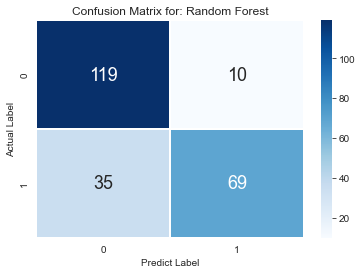

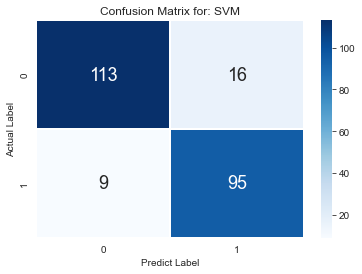

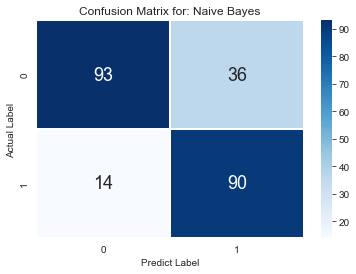

In [21]:
plot_confusion_matrix(y_test, pred_RF, "Random Forest", plt.cm.Blues)
plot_confusion_matrix(y_test, pred_SVM, "SVM", plt.cm.Blues)
plot_confusion_matrix(y_test, pred_NB, "Naive Bayes", plt.cm.Blues)

# DUMPING MODEL

In [22]:

pickle.dump(model_RF, open('models/model_RF.pkl','wb'))
pickle.dump(model_SVM, open('models/model_SVM.pkl','wb'))
pickle.dump(model_NB, open('models/model_NB.pkl','wb'))

In [23]:
#joblib.dump(model_RF,"model_RFV2.joblib")

print(X_test)
X_test = X_test.reset_index()
newdf = pd.DataFrame(pred_RF,columns=['Predicted'])
print(newdf)
df_merged = pd.concat([X_test, newdf],axis=1)
print(df_merged)